# Cryosphere model Comparison tool (CmCt) --- Gravimetry

The CmCt GRACE mascon tool compares user uploaded ice sheet model to satellite gravimetry in the form of mascon data, derived from the GRACE and GRACE-FO satellite missions. The CmCt reprojects modeled ice sheet mass change into mascon space and performs a direct quantitative comparison, calculating model-observation discrepancies, therefore bringing the ice sheet model and gravimetry data to the same spatial resolution for comparison. 

## Mascon dataset description

For comparison to the user's model, the tool currently uses the `GSFC.glb.200204_202312_RL06v2.0_OBP-ICE6GD` GRACE mascon product from 04/2002 to 12/2023 that can be requested at the NASA GSFC dataset [main distribution site](https://earth.gsfc.nasa.gov/geo/data/grace-mascons/). Future developments will include adding the functionality to automatically check the product distribution website for an updated dataset.

## Input data requirements

The input ice sheet model needs to be provided as a netCDF file. The user may upload a single input file that includes multiple years; future enhancements to this tool will allow users to upload model ensembles.

There are several requirements for the comparison:

### `Lithk` variable

The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison.

### Rectangular grid

At time of writing, models *must* be defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. (Note, NOT a lat-lon grid!) The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki). 

### Date range

The gravimetry data spans 04/2002 to 12/2023. The user can select start and end dates within this span as part of the setup for the tool.

## Tool output

from gravimetry_utils import *This tool creates a plot that GRACE mascon plot and the model mascon plot so the user can  qualitatively compare the model output with the observational data. 

In [1]:
## Import modules
import os,sys
import glob as glob
import numpy as np
import h5py
import xarray as xr
import glob as glob

import datetime

# Add the directory containing 'mascons.py' to the Python path
# Get the current working directory
current_directory = os.getcwd()
# Navigate two levels up to reach main dir
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir, os.pardir))
# Insert the specific directory into the system path
sys.path.insert(0, os.path.join(parent_directory, 'bin', 'Gravimetry'))
# Now import mascons
import mascons
from gravimetry_utils import *

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))


# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

## Select ice sheet

In [2]:
# Ice sheet
loc='AIS' # 'GIS' or 'AIS'

# Set time range for comparison
# start and end dates for model/observation comparison
start_date = '2005-01-01' # 'YYYY-MM-DD'
end_date = '2014-12-31' # 'YYYY-MM-DD'

#Mascons data path
Mascon_data_path=os.path.expanduser('/home/jovyan/shared-public/CmCt/gravimetry_code/gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd.h5')

#Model path
if loc == "GIS":
    #Model data path Greenland
    nc_file_name='/home/jovyan/shared-public/CmCt/models/lithk_GIS_IMAU_IMAUICE1_historical.nc'
elif loc == "AIS":    
    #Model data path Antartica
    nc_file_name='/home/jovyan/CmCt/notebooks/Gravimetry/lithk_AIS_AWI_PISM1_hist_std.nc'

#Output plot file name
plot_filename = os.path.splitext(os.path.basename(nc_file_name))[0] + '_mascon_comp'
output_plot_filename='/home/jovyan/CmCt/notebooks/Gravimetry/'+ plot_filename + '.png'
output_netcdf_filename='/home/jovyan/CmCt/notebooks/Gravimetry/'+ plot_filename + '.nc'

## Set polar sterographic projection definition
Currently, the CmCt expects the model data to be provided in a specific polar stereographic projection. This is hardcoded in the notebook. As a future enhancement, the projection can be obtained from the loaded model.

In [3]:
polar_stereographic=set_projection(loc)

## Upload ice sheet model

In [4]:
# load mascons
gsfc = loadGsfcMascons(Mascon_data_path)

# compute the mascon means
cmwe_delta,I_ = computeMasconMeans(gsfc, start_date, end_date,loc)



In [5]:
# load user's input model
gis_ds = loadGisModel(nc_file_name)

# Put model into mascon space
try:
    mscns_trim, lithk_mascons_cmwe = transformToGeodetic(gsfc, gis_ds, start_date, end_date,polar_stereographic)
except Exception as error:
    print('Error: model transform to geodetic failed. Terminating calculation.')
    print(error)

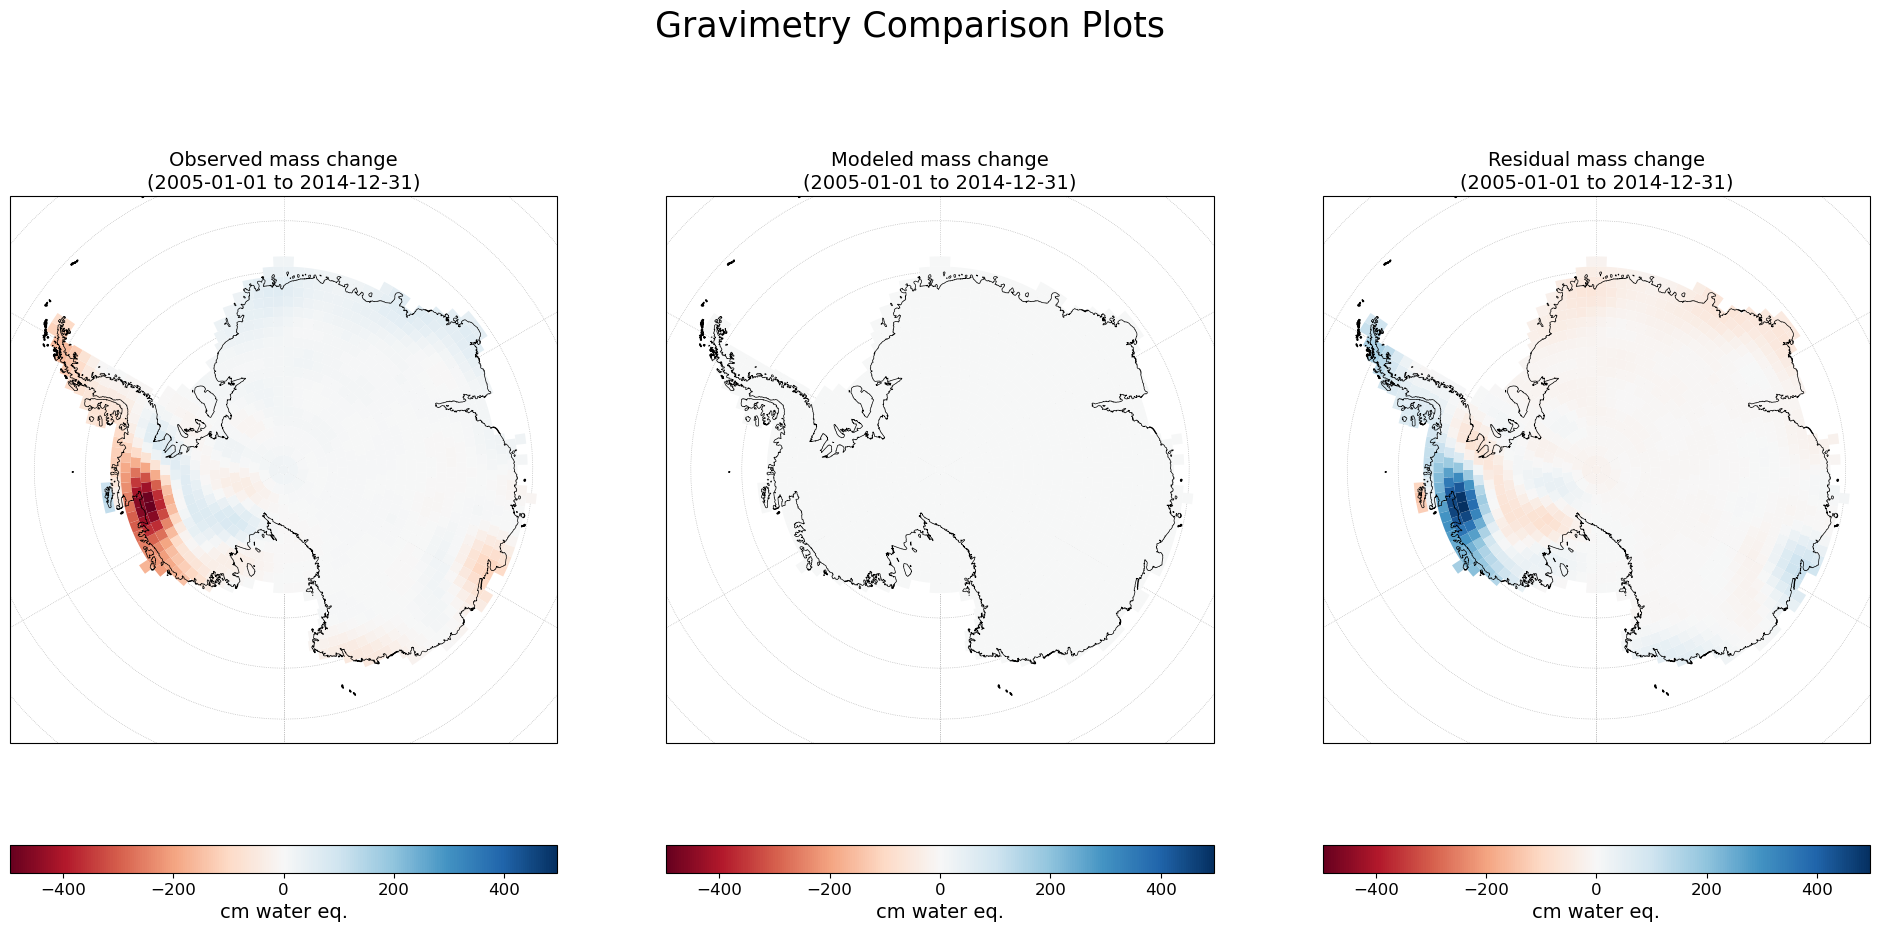

In [6]:
# calculate cmwe_diff
try:
    cmwe_diff=mscns_trim-cmwe_delta
except Exception as error:
    print('Error: Calculation failed.')
    print(error)


# Plot results
try:
    plotFigure(cmwe_delta, mscns_trim, cmwe_diff, gsfc, I_, lithk_mascons_cmwe,start_date, end_date,polar_stereographic,loc,output_plot_filename)
except Exception as error:
    print('Error: plotting failed.')
    print(error)